In [1]:
import pandas as pd
import seaborn as sns
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import os
from scipy.optimize import fsolve
import math

from bayesian.train_bn import structure_learning, parameter_learning
from preprocess.discretization import get_nodes_type, discretization, code_categories, get_nodes_sign
from bayesian.save_bn import save_structure, save_params, read_structure, read_params
from bayesian.sampling import generate_synthetics
from bayesian.calculate_accuracy import calculate_acc
from external.libpgm.hybayesiannetwork import HyBayesianNetwork
from visualization.visualization import draw_BN
from sklearn.model_selection import train_test_split
from functools import partial

pd.set_option('precision', 5)
pd.set_option('display.float_format', lambda x: '%.5f' % x)


In [2]:
if not os.path.exists('constituents-financials.csv'):
    urllib.request.urlretrieve(
        "https://datahub.io/core/s-and-p-500-companies-financials/r/constituents-financials.csv", "constituents-financials.csv")
data = pd.read_csv('constituents-financials.csv')
data = data[['Price',	'Price/Earnings', 'Dividend Yield',	'Earnings/Share',
             '52 Week Low',	'52 Week High',	'Market Cap',	'EBITDA',
             'Price/Sales',	'Price/Book', 'Sector']]
data.dropna(inplace=True)
data.reset_index(inplace=True, drop=True)
train, test = train_test_split(data, test_size=0.2, random_state=42)
test


,Price,Price/Earnings,Dividend Yield,Earnings/Share,52 Week Low,52 Week High,Market Cap,EBITDA,Price/Sales,Price/Book,Sector
456,114.87000,15.36000,0.34153,7.14000,129.74000,95.26000,11116075286,1676204000.00000,1.31587,2.21000,Health Care
73,25.19000,12.29000,3.72960,1.92000,31.80000,19.85000,5381433872,894754000.00000,2.01885,205.41000,Financials
310,74.51000,17.66000,2.15336,9.27000,102.14000,75.79000,12396862128,4708400000.00000,1.23717,1.34000,Consumer Staples
175,218.28000,18.66000,3.21381,6.27000,270.04000,214.03000,14383525286,1237886000.00000,14.18308,2.30000,Real Estate
333,47.23000,15.04000,3.00203,2.02000,53.00000,37.79240,8212509855,1448000000.00000,0.74603,9.10000,Consumer Discretionary
...,...,...,...,...,...,...,...,...,...,...,...
15,152.80000,24.22000,2.78111,13.66000,175.17000,133.63010,34638387128,2542500000.00000,4.11637,3.35000,Materials
404,387.65000,26.75000,0.84267,18.61000,435.15000,302.01010,37730994828,2160668000.00000,2.52761,13.42000,Materials
381,198.74000,25.78000,1.56128,6.95000,213.45000,147.86000,59066255840,3868000000.00000,2.29383,5.28000,Industrials
19,114.58000,19.03000,3.02623,1.57000,134.37000,106.89000,12043374429,0.00000,10.49216,2.07000,Real Estate


# Approximating Price distribution using Inverse Transform

G:\Programming\itmo_algorithms\itmo\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
G:\Programming\itmo_algorithms\itmo\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


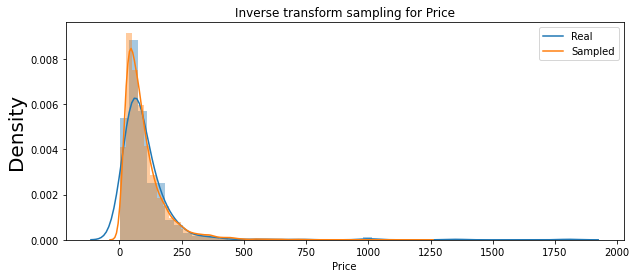

In [3]:
def inverse_transform_sampling(n, dist, param):
    gen = np.random.uniform(size=n)
    rv = dist(*param)
    return rv.ppf(gen)


params_price = st.lognorm.fit(data['Price'])
sampled_price = inverse_transform_sampling(10000, st.lognorm, params_price)


plt.figure(figsize=(10, 4))
sns.distplot(data['Price'], kde=True, label='initial data',)
sns.distplot(sampled_price, kde=True, norm_hist=True, label='sampled data')


plt.ylabel('Density', fontsize=20)
plt.title('Inverse transform sampling for Price')
plt.legend(['Real', 'Sampled'])


# Approximating Price using Accept-Reject sampling

C:\Users\morko\AppData\Local\Temp/ipykernel_9544/236949780.py:7: RuntimeWarning: divide by zero encountered in log
  exp = np.exp(-(np.log(x) - mu_)**2 / (2 * sigma_ ** 2))
C:\Users\morko\AppData\Local\Temp/ipykernel_9544/236949780.py:9: RuntimeWarning: invalid value encountered in double_scalars
  return exp / frac


Text(0.5, 1.0, 'M=3')

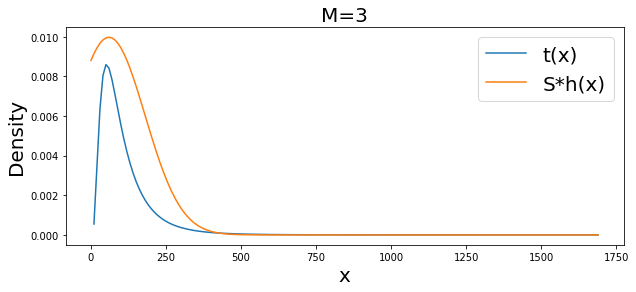

In [4]:
mu = 4.4376924074345245
sigma = 0.7008615631875369
# lognormal PDF


def lognorm_pdf(x, mu_, sigma_):
    exp = np.exp(-(np.log(x) - mu_)**2 / (2 * sigma_ ** 2))
    frac = (x * sigma_ * (2 * np.pi) ** 0.5)
    return exp / frac

# normal PDF


def g(x, mu_, sigma_):
    return 1/np.sqrt(2*np.pi)/sigma_ * np.exp(-0.5*((x-mu_)/sigma_)**2)


upper_params = 60, 120

M = 3
x_vals = np.arange(0, 1700, 10)
f_vals = [lognorm_pdf(x, mu, sigma) for x in x_vals]
g_vals = g(x_vals, *upper_params)
plt.figure(figsize=(10, 4))
plt.plot(x_vals, f_vals)
plt.plot(x_vals, M*g_vals)
plt.xlabel('x', fontsize=20)
plt.ylabel('Density', fontsize=20)
plt.legend(['t(x)', 'S*h(x)'], fontsize=20)

plt.title("M=%s" % M, fontsize=20)


C:\Users\morko\AppData\Local\Temp/ipykernel_9544/236949780.py:7: RuntimeWarning: invalid value encountered in log
  exp = np.exp(-(np.log(x) - mu_)**2 / (2 * sigma_ ** 2))


Num Samples Collected: 33185
Efficiency: 0.332


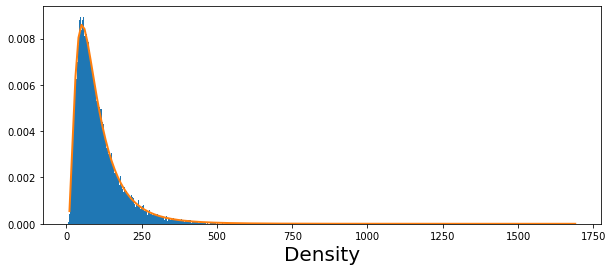

In [5]:
# collect all accepted samples here
samples = []

# try this many candidates
N = 100000

for _ in range(N):
    # sample a candidate
    candidate = np.random.normal(*upper_params)

    # calculate probability of accepting this candidate
    prob_accept = lognorm_pdf(candidate, mu, sigma) / (M*g(candidate, *upper_params))

    # accept with the calculated probability
    if np.random.random() < prob_accept:
        samples.append(candidate)

plt.figure(figsize=(10, 4))
plt.hist(samples, bins=200, density=True)
plt.xlabel('x', fontsize=20)
plt.xlabel('Density', fontsize=20)
plt.plot(x_vals, [f for f in f_vals], linewidth=2)
# plt.ylim(0, 0.015)
print("Num Samples Collected: %s"%len(samples))
print("Efficiency: %s"%round(len(samples) / N, 3))
# .title('Empirical Exp. Value: %s\nTrue Exp. Value: %s'%(round(np.mean(samples), 2), round(np.mean(TRUE_EXP), 2)), fontsize=20)


# Approximating Dividend Yield distribution using Inverse Transform

G:\Programming\itmo_algorithms\itmo\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
G:\Programming\itmo_algorithms\itmo\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


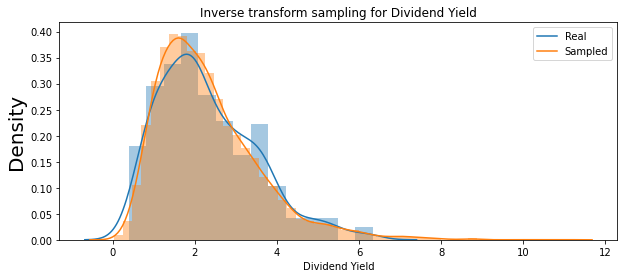

In [6]:
# same preprocessing as in lab 1
div_yield = data['Dividend Yield']
div_yield = div_yield[div_yield.between(div_yield.quantile(0.2), div_yield.quantile(.99))].reset_index(drop=True)
params_div_yield = st.lognorm.fit(div_yield)
sampled_div_yield = inverse_transform_sampling(10000, st.lognorm, params_div_yield)


plt.figure(figsize=(10, 4))
sns.distplot(div_yield, kde=True, label='initial data',)
sns.distplot(sampled_div_yield, kde=True, norm_hist=True, label='sampled data')


plt.ylabel('Density', fontsize=20)
plt.title('Inverse transform sampling for Dividend Yield')
plt.legend(['Real', 'Sampled'])

# Approximating Dividend Yield using Accept-Reject sampling

C:\Users\morko\AppData\Local\Temp/ipykernel_9544/4216565273.py:5: RuntimeWarning: divide by zero encountered in log
  exp = np.exp(-(np.log(x) - mu)**2 / (2 * sigma ** 2))
C:\Users\morko\AppData\Local\Temp/ipykernel_9544/4216565273.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return exp / frac


Text(0.5, 1.0, 'M=2')

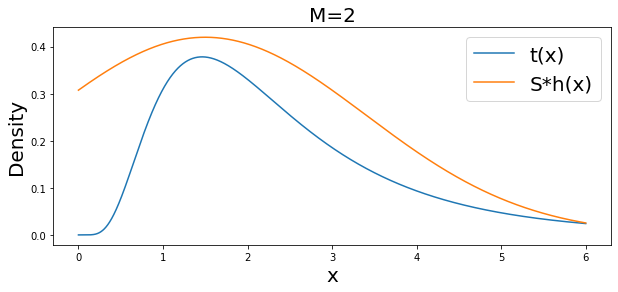

In [7]:
mu = 0.7423118497542172
sigma = 0.6016495934841037
# lognormal PDF
def lognorm_pdf(x, mu, sigma):
    exp = np.exp(-(np.log(x) - mu)**2 / (2 * sigma ** 2))
    frac = (x * sigma * (2 * np.pi) ** 0.5)
    return exp / frac

# normal PDF


def g(x, mu, sigma):
    return 1/np.sqrt(2*np.pi)/sigma * np.exp(-0.5*((x-mu)/sigma)**2)

upper_params = 1.5, 1.9
M = 2
x_vals = np.arange(0, 6, 1e-4)
f_vals = [lognorm_pdf(x, mu, sigma) for x in x_vals]
g_vals = g(x_vals, *upper_params)
plt.figure(figsize=(10, 4))
plt.plot(x_vals, f_vals)
plt.plot(x_vals, M*g_vals)
plt.xlabel('x', fontsize=20)
plt.ylabel('Density', fontsize=20)
plt.legend(['t(x)', 'S*h(x)'], fontsize=20)

plt.title("M=%s" % M, fontsize=20)


C:\Users\morko\AppData\Local\Temp/ipykernel_9544/4216565273.py:5: RuntimeWarning: invalid value encountered in log
  exp = np.exp(-(np.log(x) - mu)**2 / (2 * sigma ** 2))


Num Samples Collected: 48631
Efficiency: 0.486


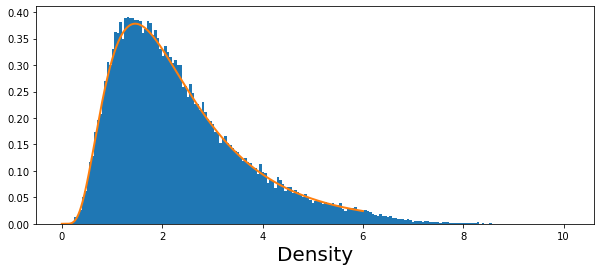

In [8]:
# collect all accepted samples here
samples = []

# try this many candidates
N = 100000

for _ in range(N):
    # sample a candidate
    candidate = np.random.normal(*upper_params)

    # calculate probability of accepting this candidate
    prob_accept = lognorm_pdf(candidate, mu, sigma) / (M*g(candidate, *upper_params))

    # accept with the calculated probability
    if np.random.random() < prob_accept:
        samples.append(candidate)

plt.figure(figsize=(10, 4))
plt.hist(samples, bins=200, density=True)
plt.xlabel('x', fontsize=20)
plt.xlabel('Density', fontsize=20)
plt.plot(x_vals, [f for f in f_vals], linewidth=2)
# plt.ylim(0, 0.015)
print("Num Samples Collected: %s"%len(samples))
print("Efficiency: %s"%round(len(samples) / N, 3))
# .title('Empirical Exp. Value: %s\nTrue Exp. Value: %s'%(round(np.mean(samples), 2), round(np.mean(TRUE_EXP), 2)), fontsize=20)


# Approximating Earnings/Share using Inverse Transform Sampling

G:\Programming\itmo_algorithms\itmo\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
G:\Programming\itmo_algorithms\itmo\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


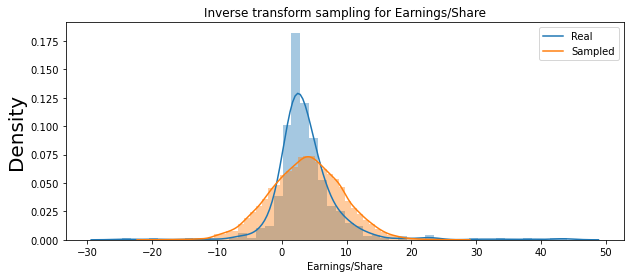

In [18]:

params_earnings = st.norm.fit(data['Earnings/Share'])
sampled_earnings = inverse_transform_sampling(10000, st.norm, params_earnings)


plt.figure(figsize=(10, 4))
sns.distplot(data['Earnings/Share'], kde=True, label='initial data',)
sns.distplot(sampled_earnings, kde=True, norm_hist=True, label='sampled data')


plt.ylabel('Density', fontsize=20)
plt.title('Inverse transform sampling for Earnings/Share')
plt.legend(['Real', 'Sampled'])

# Approximating Earnings/Share using Accept Reject Sampling

Num Samples Collected: 50098
Efficiency: 0.501


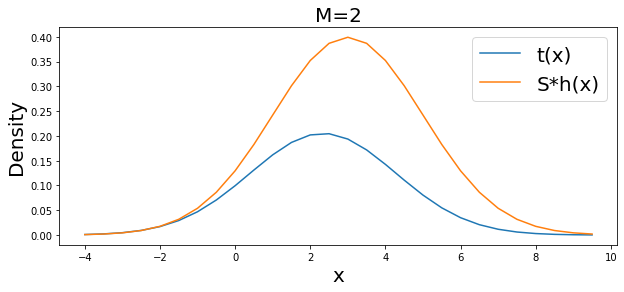

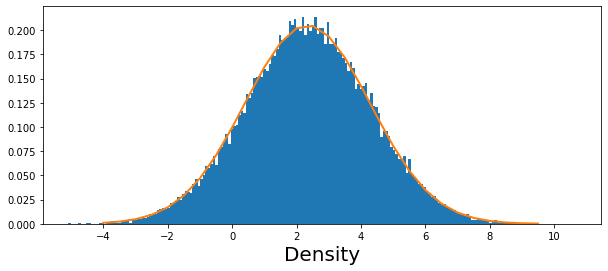

In [10]:
# normal PDF
mu = 2.3402284263959388
sigma = 1.9454675161643853
def normal_pdf(x, mu_, sigma_):
    
    return 1/np.sqrt(2*np.pi)/sigma * np.exp(-0.5*((x-mu)/sigma)**2)

# normal PDF


def g(x, mu_, sigma_):
    return 1/np.sqrt(2*np.pi)/sigma_ * np.exp(-0.5*((x-mu_)/sigma_)**2)

upper_params = 3, 2

M = 2
x_vals = np.arange(-4, 10, 0.5)
f_vals = [normal_pdf(x, mu, sigma) for x in x_vals]
g_vals = g(x_vals, *upper_params)
plt.figure(figsize=(10, 4))
plt.plot(x_vals, f_vals)
plt.plot(x_vals, M*g_vals)
plt.xlabel('x', fontsize=20)
plt.ylabel('Density', fontsize=20)
plt.legend(['t(x)', 'S*h(x)'], fontsize=20)

plt.title("M=%s" % M, fontsize=20)

# collect all accepted samples here
samples = []

# try this many candidates
N = 100000

for _ in range(N):
    # sample a candidate
    candidate = np.random.normal(*upper_params)

    # calculate probability of accepting this candidate
    prob_accept =normal_pdf(candidate, mu, sigma) / (M*g(candidate, *upper_params))

    # accept with the calculated probability
    if np.random.random() < prob_accept:
        samples.append(candidate)

plt.figure(figsize=(10, 4))
plt.hist(samples, bins=200, density=True)
plt.xlabel('x', fontsize=20)
plt.xlabel('Density', fontsize=20)
plt.plot(x_vals, [f for f in f_vals], linewidth=2)
# plt.ylim(0, 0.015)
print("Num Samples Collected: %s"%len(samples))
print("Efficiency: %s"%round(len(samples) / N, 3))
# .title('Empirical Exp. Value: %s\nTrue Exp. Value: %s'%(round(np.mean(samples), 2), round(np.mean(TRUE_EXP), 2)), fontsize=20)

# Estimating correlations between targets and predictors

In [11]:
data.corr()

,Price,Price/Earnings,Dividend Yield,Earnings/Share,52 Week Low,52 Week High,Market Cap,EBITDA,Price/Sales,Price/Book
Price,1.00000,0.19917,-0.24534,0.60903,0.99508,0.98277,0.40775,0.18064,0.18108,0.02351
Price/Earnings,0.19917,1.00000,-0.20088,0.00888,0.18976,0.14763,0.13256,0.00081,0.18701,0.00037
Dividend Yield,-0.24534,-0.20088,1.00000,-0.08826,-0.24542,-0.20907,-0.02687,0.12239,-0.08112,0.08907
Earnings/Share,0.60903,0.00888,-0.08826,1.00000,0.60611,0.62302,0.19443,0.17794,-0.03933,0.03164
52 Week Low,0.99508,0.18976,-0.24542,0.60611,1.00000,0.98489,0.39983,0.17677,0.18849,0.02318
52 Week High,0.98277,0.14763,-0.20907,0.62302,0.98489,1.00000,0.37585,0.17930,0.17288,0.01765
Market Cap,0.40775,0.13256,-0.02687,0.19443,0.39983,0.37585,1.00000,0.77072,0.09393,0.03422
EBITDA,0.18064,0.00081,0.12239,0.17794,0.17677,0.17930,0.77072,1.00000,-0.03793,0.03530
Price/Sales,0.18108,0.18701,-0.08112,-0.03933,0.18849,0.17288,0.09393,-0.03793,1.00000,0.01230
Price/Book,0.02351,0.00037,0.08907,0.03164,0.02318,0.01765,0.03422,0.03530,0.01230,1.00000


In [17]:
corr = data.corr()
corr[['Price', 'Dividend Yield', 'Earnings/Share']]

,Price,Dividend Yield,Earnings/Share
Price,1.00000,-0.24534,0.60903
Price/Earnings,0.19917,-0.20088,0.00888
Dividend Yield,-0.24534,1.00000,-0.08826
Earnings/Share,0.60903,-0.08826,1.00000
52 Week Low,0.99508,-0.24542,0.60611
52 Week High,0.98277,-0.20907,0.62302
Market Cap,0.40775,-0.02687,0.19443
EBITDA,0.18064,0.12239,0.17794
Price/Sales,0.18108,-0.08112,-0.03933
Price/Book,0.02351,0.08907,0.03164


# Building Bayes Network on Correlation Analysis

In [12]:

nodes_type = get_nodes_type(train)
nodes_type['Market Cap'] = 'cont'
print("Nodes type:\n", nodes_type)
nodes_sign = get_nodes_sign(train)
nodes_sign['Market Cap'] = 'pos'
print("Nodes sign:\n", nodes_sign)
bayes_manual = dict(
    {'V': ['Price',
           'Price/Earnings',
           'Dividend Yield',
           'Earnings/Share',
           '52 Week Low',
           '52 Week High',
           'Market Cap',
           'EBITDA',
           'Price/Sales',
           'Price/Book',
           'Sector'],
     'E': [

        ['52 Week High', 'Price'],
        ['52 Week Low', 'Price'],
        ['Market Cap', 'Price'],

        ['52 Week High', 'Dividend Yield'],
        ['52 Week Low', 'Dividend Yield'],
        ['Price', 'Dividend Yield'],


        ['52 Week High', 'Earnings/Share'],
        ['52 Week Low', 'Earnings/Share'],
        ['Price', 'Earnings/Share'],
    ]
    }
)
print("Obtained network structure", bayes_manual)

draw_BN(bayes_manual, nodes_type, 's&p_bayes_manual')


Nodes type:
 {'Price': 'cont', 'Price/Earnings': 'cont', 'Dividend Yield': 'cont', 'Earnings/Share': 'cont', '52 Week Low': 'cont', '52 Week High': 'cont', 'Market Cap': 'cont', 'EBITDA': 'cont', 'Price/Sales': 'cont', 'Price/Book': 'cont', 'Sector': 'disc'}
Nodes sign:
 {'Price': 'pos', 'Price/Earnings': 'neg', 'Dividend Yield': 'pos', 'Earnings/Share': 'neg', '52 Week Low': 'pos', '52 Week High': 'pos', 'EBITDA': 'neg', 'Price/Sales': 'pos', 'Price/Book': 'pos', 'Market Cap': 'pos'}
Obtained network structure {'V': ['Price', 'Price/Earnings', 'Dividend Yield', 'Earnings/Share', '52 Week Low', '52 Week High', 'Market Cap', 'EBITDA', 'Price/Sales', 'Price/Book', 'Sector'], 'E': [['52 Week High', 'Price'], ['52 Week Low', 'Price'], ['Market Cap', 'Price'], ['52 Week High', 'Dividend Yield'], ['52 Week Low', 'Dividend Yield'], ['Price', 'Dividend Yield'], ['52 Week High', 'Earnings/Share'], ['52 Week Low', 'Earnings/Share'], ['Price', 'Earnings/Share']]}
saving on ../visualization_result

G:\Programming\itmo_algorithms\itmo\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
G:\Programming\itmo_algorithms\itmo\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
G:\Programming\itmo_algorithms\itmo\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexib

({}, {'Price': 14.012, 'Dividend Yield': 1.463, 'Earnings/Share': 4.421})


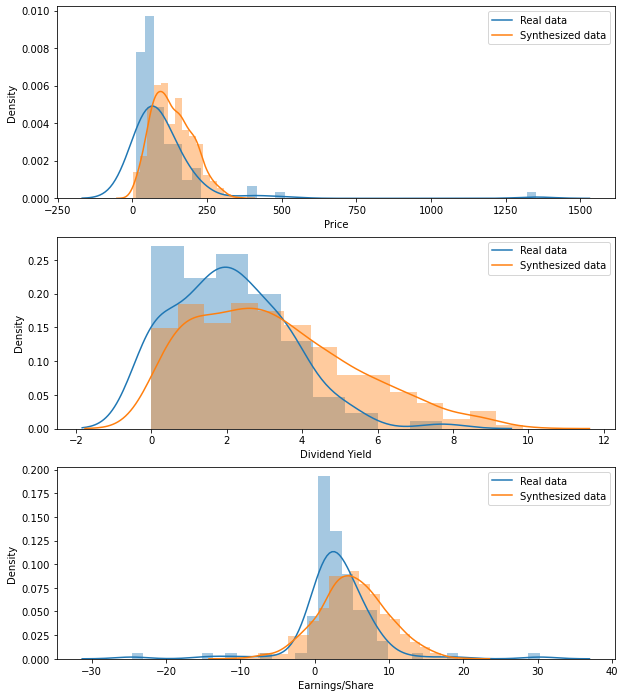

In [13]:

params = parameter_learning(train, nodes_type, bayes_manual, 'simple')
save_structure(bayes_manual, 's&p_bayes_manual_structure')
skel = read_structure('s&p_bayes_manual_structure')
save_params(params, 's&p_bayes_manual_params')
params = read_params('s&p_bayes_manual_params')
bayes_manual = HyBayesianNetwork(skel, params)
synth_df = generate_synthetics(bayes_manual, nodes_sign, 'simple', 800)

fix, ax = plt.subplots(3, 1, figsize=(10, 12))


sns.distplot(test['Price'], ax=ax[0])
sns.distplot(synth_df['Price'], ax=ax[0])
ax[0].legend(['Real data', 'Synthesized data'])

sns.distplot(test['Dividend Yield'], ax=ax[1])
sns.distplot(synth_df['Dividend Yield'], ax=ax[1])
ax[1].legend(['Real data', 'Synthesized data'])

sns.distplot(test['Earnings/Share'], ax=ax[2])
sns.distplot(synth_df['Earnings/Share'], ax=ax[2])
ax[2].legend(['Real data', 'Synthesized data'])

print(calculate_acc(bayes_manual, data, [
      'Price', 'Dividend Yield', 'Earnings/Share'], 'simple')[0:2])


# Bayes Network (HC algorithm)

In [14]:

coded_data, coder = code_categories(
    train, 'label', ['Sector'])
discrete_data, coder = discretization(coded_data, 'equal_frequency',
                                      ['Price',	'Price/Earnings', 'Dividend Yield',	'Earnings/Share',
                                       '52 Week Low',	'52 Week High',	'Market Cap',	'EBITDA',
                                       'Price/Sales',	'Price/Book'])
bayes_hc = structure_learning(discrete_data, 'HC', nodes_type, 'K2')
print("Obtained network structure", bayes_hc)
draw_BN(bayes_hc, nodes_type, 's&p_bayes_hc')


params = parameter_learning(train, nodes_type, bayes_hc, 'simple')
save_structure(bayes_hc, 's&p_bayes_hc_structure')
skel = read_structure('s&p_bayes_hc_structure')
save_params(params, 'p_bayes_hc_params')
params = read_params('p_bayes_hc_params')
bayes_hc = HyBayesianNetwork(skel, params)
synth_df = generate_synthetics(bayes_hc, nodes_sign, 'simple', 800)


Obtained network structure {'V': ['Price', 'Price/Earnings', 'Dividend Yield', 'Earnings/Share', '52 Week Low', '52 Week High', 'Market Cap', 'EBITDA', 'Price/Sales', 'Price/Book', 'Sector'], 'E': [['Price', '52 Week Low'], ['Price/Earnings', 'Price/Sales'], ['Dividend Yield', 'Price/Earnings'], ['52 Week Low', '52 Week High'], ['52 Week Low', 'Earnings/Share'], ['EBITDA', 'Market Cap'], ['Price/Book', 'Price'], ['Price/Book', 'Price/Earnings'], ['Sector', 'Dividend Yield'], ['Sector', 'Price/Sales'], ['Sector', 'EBITDA'], ['Sector', 'Price/Book']]}
saving on ../visualization_result/s&p_bayes_hc.html
g:\Programming\multidimensional_data_processing\BAMT\s&p_bayes_hc.html


G:\Programming\itmo_algorithms\itmo\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
G:\Programming\itmo_algorithms\itmo\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
G:\Programming\itmo_algorithms\itmo\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexib

({}, {'Price': 157.802, 'Dividend Yield': 1.264, 'Earnings/Share': 5.614})


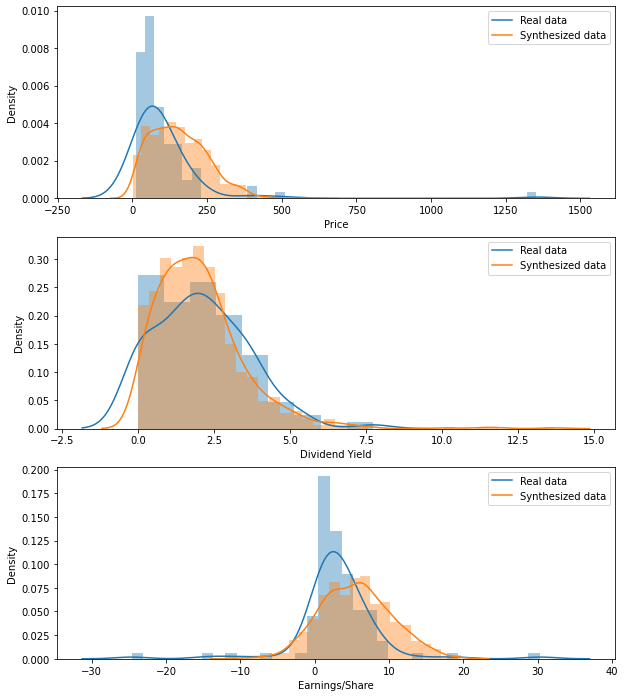

In [15]:
fix, ax = plt.subplots(3, 1, figsize=(10, 12))

sns.distplot(test['Price'], ax=ax[0])
sns.distplot(synth_df['Price'], ax=ax[0])
ax[0].legend(['Real data', 'Synthesized data'])

sns.distplot(test['Dividend Yield'], ax=ax[1])
sns.distplot(synth_df['Dividend Yield'], ax=ax[1])
ax[1].legend(['Real data', 'Synthesized data'])

sns.distplot(test['Earnings/Share'], ax=ax[2])
sns.distplot(synth_df['Earnings/Share'], ax=ax[2])
ax[2].legend(['Real data', 'Synthesized data'])

print(calculate_acc(bayes_hc, test, [
      'Price', 'Dividend Yield', 'Earnings/Share'], 'simple')[0:2])


# Bayes network (Evo algorithm)

In [16]:
bayes_evo = structure_learning(discrete_data, 'evo', nodes_type, 'MI')
print("Obtained network structure", bayes_evo)
draw_BN(bayes_evo, nodes_type, 's&p_bayes_evo')

params = parameter_learning(train, nodes_type, bayes_evo, 'simple')
save_structure(bayes_evo, 's&p_bayes_evo_structure')
skel = read_structure('s&p_bayes_evo_structure')
save_params(params, 's&p_bayes_evo_params')
params = read_params('s&p_bayes_evo_params')
bayes_evo = HyBayesianNetwork(skel, params)
synth_df = generate_synthetics(bayes_evo, nodes_sign, 'simple', 800)



G:\Programming\itmo_algorithms\itmo\lib\site-packages\pgmpy\models\BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNewtork class, BayesianModel will be removed in future.
  warnings.warn(


Best metric is 12.0561
Generation num: 0
max_depth: 6, no improvements: 0
spent time: 0.0 min
Best metric is 12.0561
Generation num: 1
max_depth: 6, no improvements: 1
spent time: 0.1 min
Best metric is 12.050999999999998
Generation num: 2
max_depth: 6, no improvements: 0
spent time: 0.1 min
Best metric is 12.026
Generation num: 3
max_depth: 6, no improvements: 0
spent time: 0.1 min
Best metric is 12.0201
Generation num: 4
max_depth: 6, no improvements: 0
spent time: 0.2 min
Best metric is 12.0167
Generation num: 5
max_depth: 6, no improvements: 0
spent time: 0.2 min
Best metric is 11.966899999999999
Generation num: 6
max_depth: 6, no improvements: 0
spent time: 0.3 min
Best metric is 11.963999999999999
Generation num: 7
max_depth: 6, no improvements: 0
spent time: 0.3 min
Best metric is 11.962500000000002
Generation num: 8
max_depth: 6, no improvements: 0
spent time: 0.4 min
Best metric is 11.962500000000002
Generation num: 9
max_depth: 6, no improvements: 1
spent time: 0.5 min
Best m

KeyboardInterrupt: 

G:\Programming\itmo_algorithms\itmo\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
G:\Programming\itmo_algorithms\itmo\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
G:\Programming\itmo_algorithms\itmo\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexib

({}, {'Price': 101.417, 'Dividend Yield': 1.498, 'Earnings/Share': 3.486})


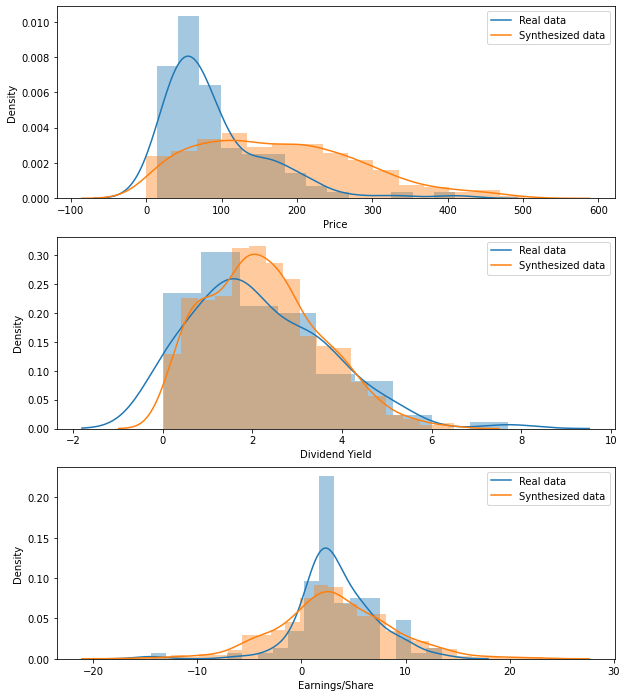

In [ ]:
fix, ax = plt.subplots(3, 1, figsize=(10, 12))

sns.distplot(test['Price'], ax=ax[0])
sns.distplot(synth_df['Price'], ax=ax[0])
ax[0].legend(['Real data', 'Synthesized data'])

sns.distplot(test['Dividend Yield'], ax=ax[1])
sns.distplot(synth_df['Dividend Yield'], ax=ax[1])
ax[1].legend(['Real data', 'Synthesized data'])

sns.distplot(test['Earnings/Share'], ax=ax[2])
sns.distplot(synth_df['Earnings/Share'], ax=ax[2])
ax[2].legend(['Real data', 'Synthesized data'])

print(calculate_acc(bayes_evo, test, [
      'Price', 'Dividend Yield', 'Earnings/Share'], 'simple')[0:2])
